In [2]:
!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.geocoding import geocode
from IPython.display import display, Image
from arcgis.raster import ImageryLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geometry import Polygon, Envelope
from arcgis.raster.functions import clip

from osgeo import gdal, gdalconst, gdal_array
import pylab as plt
import warnings
warnings.simplefilter('ignore')
%pylab inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Populating the interactive namespace from numpy and matplotlib


In [149]:
gis = GIS(url='https://nkwjones.maps.arcgis.com',username='nj935_',password='Bemelmans1')
print("Logged on as {}".format(gis.properties.user["username"]))

Logged on as nj935_


### 1. Get data: borders, elevation, population


In [4]:
ESRI_pop = gis.content.get('625e9da1afed40b78aaf412f519b22d3')
pop_lyr = ESRI_pop.layers[0]

In [5]:
ESRI_elevation = gis.content.get('58a541efc59545e6b7137f961d7de883')
elev_lyr = ESRI_elevation.layers[0]

In [6]:
world_boundaries = gis.content.get("2b93b06dc0dc4e809d3c8db5cb96ba69")
boundary_lyr = world_boundaries.layers[0]

### 2. Create a table of SIDS
- name
- national borders (geometry object)
- bounding box (geometry object using ArcGIS geocoder)

In [152]:
SIDS = [
'Antigua and Barbuda','Cook Islands','Cape Verde','Federated States of Micronesia','Comoros',
    'Bahamas','Fiji','Guinea-Bissau','Barbados','Maldives','Belize','Mauritius','Kiribati','São Tomé and Príncipe',
    'Cuba','Marshall Islands','Seychelles','Dominica','Nauru','Dominican Republic','Grenada',
    'Niue','Guyana','Haiti','Palau','Jamaica','Papua New Guinea','Samoa','Solomon Islands',
    'Timor-Leste','Saint Kitts and Nevis','Tonga','Saint Lucia','Tuvalu',
    'Saint Vincent and the Grenadines','Vanuatu','Suriname','Trinidad and Tobago']

In [153]:
SIDS_table = pd.DataFrame.spatial.from_layer(boundary_lyr)
SIDS_table.drop(columns=['AFF_ISO','FID','ISO','COUNTRYAFF'],inplace=True)
SIDS_table = SIDS_table[SIDS_table['Country'].isin(SIDS)]
SIDS_table.set_index("Country",inplace=True)
SIDS_table['Country'] = SIDS_table.index

In [205]:
SIDS_table.head(2)

,SHAPE,Country
Country,,
Guyana,"{""rings"": [[[-6475746.20510377, 760125.6448030...",Guyana
Suriname,"{""rings"": [[[-6136816.88138343, 649239.6407875...",Suriname


In [154]:
m = gis.map()
m

MapView(layout=Layout(height='400px', width='100%'))

In [206]:
SIDS_table.spatial.plot(map_widget=m)

True

### 3. Output population and elevation rasters

In [11]:
! mkdir "rasters_sept_10"

mkdir: rasters_sept_10: File exists


In [ ]:
# Variables for the raster export function
# set the export folder here

folder = 'rasters_sept_10'
sr = pop_lyr.properties.spatialReference
names_dict = {pop_lyr:"pop",elev_lyr:"elev"}

In [ ]:
countries = 

In [81]:
# Function to output rasters for elevation or population, clipped to national borders

def output_raster(country,layer):
    
        filename = names_dict[layer]+'_'+str(country)

        AOI = geocode(country,category = "Country",out_sr=sr)[0]['extent']
        AOI['spatialReference'] = sr
        layer.extent = AOI

        clipped = clip(layer,SIDS_table.at[country,'SHAPE'])
        clipped.export_image(f='image', bbox = AOI, export_format='tiff',
                        save_folder = folder, save_file=filename)


In [83]:
for i in SIDS_table.Country:
    output_raster(i, pop_lyr)
    output_raster(i, elev_lyr)

### 4. Visualize the results

In [ ]:
def show_elev(country,max_elev):
    elev_data = gdal.Open(folder + '/elev_' + country, gdal.GA_ReadOnly)
    elev = elev_data.ReadAsArray()
    
    pop_data = gdal.Open(folder + '/pop_' + country, gdal.GA_ReadOnly)
    pop = pop_data.ReadAsArray()
    
    mask = ((elev>0) & (elev<max_elev))
    plt.imshow(mask)
    plt.title("{}: Land up to {} m".format(country,max_elev))

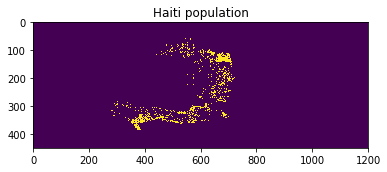

In [53]:
country = "Haiti"
img_data = gdal.Open(folder+'/pop_'+country, gdal.GA_ReadOnly)
img = img_data.ReadAsArray()
plt.imshow((img>1) & (img<100000))
plt.title("{} population".format(country));

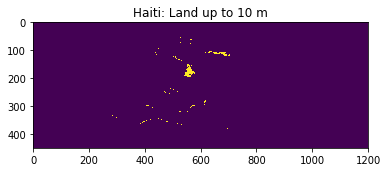

In [203]:
show_elev("Haiti",10)

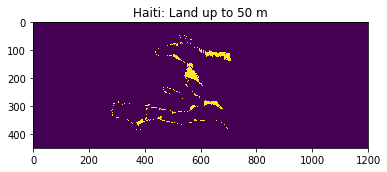

In [204]:
show_elev("Haiti",50)

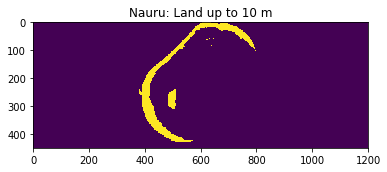

In [117]:
show_elev("Nauru",10)

### 5. Calculate population at different elevations

In [88]:
def count_pop_exposed(country):
    elev_data = gdal.Open(folder + '/elev_' + country, gdal.GA_ReadOnly)
    elev = elev_data.ReadAsArray()
    
    pop_data = gdal.Open(folder + '/pop_' + country, gdal.GA_ReadOnly)
    pop = pop_data.ReadAsArray()
    
    mask_land = (elev>0)
    mask_100m = ((elev>0) & (elev<100))
    mask_50m = ((elev>0) & (elev<50))
    mask_20m = ((elev>0) & (elev<20))
    mask_10m = ((elev>0) & (elev<10))
    mask_5m = ((elev>0) & (elev<5))
    
    output = [np.sum(pop[mask_land]),np.sum(pop[mask_100m]),np.sum(pop[mask_50m]),
          np.sum(pop[mask_20m]),np.sum(pop[mask_10m]),np.sum(pop[mask_5m])]
    
    pop_exposed = pd.DataFrame({"elevation":["all",100,50,20,10,5],"population":output})
    pop_exposed['percent_total'] = pop_exposed['population'] / pop_exposed.population[0]
    
    #pop_exposed.plot.bar(x="elevation",y='percent_total',color='b',
    #                 title='{}: Percent population by meters above sea level'.format(country))
    
    return(pop_exposed.population.tolist(),pop_exposed.percent_total.tolist())

In [105]:
df_pc = pd.DataFrame({"Country":SIDS_table.Country}).set_index('Country').T

In [106]:
for i in df_total.columns:
    df_total[i] = count_pop_exposed(i)[0]
    
for i in df_pc.columns:
    df_pc[i] = count_pop_exposed(i)[1]

### 6. Plot figures

In [107]:
df_pc=df_pc.T
df_pc.columns=["all",'100m','50m','20m','10m','5m']
df_pc.head()

,all,100m,50m,20m,10m,5m
Country,,,,,,
Guyana,1.0,0.794286,0.794286,0.777143,0.720000,0.657143
Suriname,1.0,0.994286,0.994286,0.977143,0.777143,0.531429
Trinidad and Tobago,1.0,0.999998,0.999995,0.995523,0.959804,0.848197
Cook Islands,1.0,1.000000,1.000000,0.428571,0.285714,0.142857
Niue,1.0,1.000000,0.999753,0.999745,0.999745,0.999745


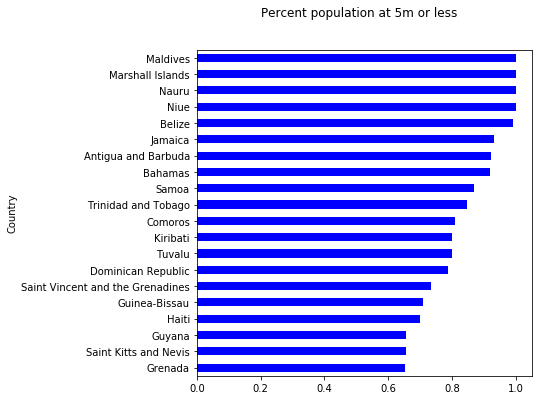

In [146]:
f,ax = plt.subplots(figsize=[6,6])
df_pc['5m'].sort_values(ascending=False)[:20].plot(kind='barh',figsize=[6,6],color='blue',ax=ax)
plt.suptitle("Percent population at 5m or less")
ax.invert_yaxis()

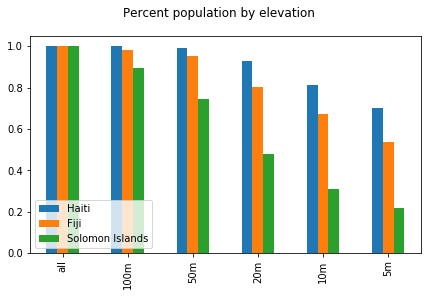

In [224]:
f,ax = plt.subplots(figsize=[7,4])
df_pc.T[['Haiti','Fiji','Solomon Islands']].plot(kind='bar',ax=ax)
ax.legend(loc=3)
f.suptitle('Percent population by elevation');

### 7. Inspect on a map

In [228]:
m1 = gis.map("Haiti")
m1

MapView(layout=Layout(height='400px', width='100%'))

In [231]:
m1.add_layer(pop_lyr)